# About this notebook

TabNetMultiTaskClassifier is still under development, I'm sharing this now in a co-construction approach.

Please share your feedback as comments here or directly in the corresponding PR on the github repo : https://github.com/dreamquark-ai/tabnet/pull/184

Once carefully reviewed I'll release this in the official repo.

If you have questions about the model please first have a look at the README here : https://github.com/dreamquark-ai/tabnet/blob/feat/MultiTaskClassification/README.md

Maybe have a look at this video for more in depth explanations : https://youtu.be/ysBaZO8YmX8 

# About TabNetMultiTaskClassifier

TabNetMultiTaskClassifier is a new class of pytorch-tabnet, it allows you to easily deal with multi task classification problem. (Note: for multi task regression problems you can use TabNetRegressor).

Some of the available features are:

- any number of tasks is allowed
- each task can have any number of labels
- you can pass different loss functions for each task by giving a corresponding list of loss function during fit

# About the competition

I am not going to share a full running submission as I did not started the competition yet and I'd like people to try a solution of their own.

This should be enough for people to start playing around, feel free to fork this in order to get a score.
If you end up with a good scoring kernel with a few twick please share it publicly, we are still very early in the competition and TabNet is easy to use and open source.

Disclaimer : I actually don't know how competitive this simple notebook will be, but this is just a baseline to improve upon!


# About pytorch-tabnet

Pytorch-tabnet is an open source project, feel free to contribute!


**Good luck to all, have fun!**

# Installing pytorch-tabnet from the MultiTask branch (not official branch)

In [1]:
!pip uninstall -y typing # this should avoid  AttributeError: type object 'Callable' has no attribute '_abc_registry'

!pip install  "git+https://github.com/dreamquark-ai/tabnet.git@develop#egg=pytorch_tabnet" --upgrade

Found existing installation: typing 3.7.4.3
Uninstalling typing-3.7.4.3:
  Successfully uninstalled typing-3.7.4.3
  Cloning https://github.com/dreamquark-ai/tabnet.git (to revision develop) to /tmp/pip-install-ljucvwxn/pytorch-tabnet
  Installing build dependencies ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pytorch-tabnet: filename=pytorch_tabnet-1.2.0-py3-none-any.whl size=26228 sha256=ac2c7e407862d7585d85c62a72923fb6452af0a4d1138226a2389b387d31fb78
  Stored in directory: /tmp/pip-ephem-wheel-cache-z72zixrq/wheels/a6/8e/aa/6f5ef6a2e389c8b5f7ea1c74bbb03ece8773b03c2b8955c334
Successfully built pytorch-tabnet
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Import libraries

In [1]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss

import pandas as pd
import numpy as np
np.random.seed(0)

from tqdm.notebook import tqdm

import os

from matplotlib import pyplot as plt
%matplotlib inline

# Download data

In [16]:
dataset_name = "lish-moa"
train = pd.read_csv("train_features.csv")
train_targets = pd.read_csv('train_targets_scored.csv')
train_targets.drop(columns=["sig_id"], inplace=True)

test = pd.read_csv('test_features.csv')

# Random Split, do something smarter if you want)

In [17]:
np.random.seed(0)
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"], p =[.85, .15], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index

# Simple preprocessing


Copy/pasted from my example notebooks, don't know if we have missing values.

Label encode categorical features and fill empty cells.


Do any smarter preprocessing if you want.

In [18]:
# Encoding train set and test set

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in tqdm(train.columns):
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        try:
            test[col] = test[col].fillna("VV_likely")
            test[col] = l_enc.transform(test[col].values)
        except:
            print(f"Column {col} does not exist in test set")
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        training_mean = train.loc[train_indices, col].mean()
        train.fillna(training_mean, inplace=True)
        test.fillna(training_mean, inplace=True)

sig_id 23814
Column sig_id does not exist in test set
cp_type 2
cp_time 3
cp_dose 2
Set 2
Column Set does not exist in test set



# Define categorical features for categorical embeddings

In [19]:
unused_feat = ['Set', 'sig_id'] # Let's not use splitting sets and sig_id

features = [ col for col in train.columns if col not in unused_feat] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Creating train/valid/test matrices

In [29]:
NB_TASKS = 206 

X_train = train[features].values[train_indices]
y_train = train_targets.values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train_targets.values[valid_indices]


X_test = test[features].values



# Define network and parameters

### This is a set of basic parameters, happy tuning!

In [30]:

clf = TabNetMultiTaskClassifier(n_steps=1,
                                cat_idxs=cat_idxs,
                                cat_dims=cat_dims,
                                cat_emb_dim=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50, # how to use learning rate scheduler
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       
                      )

Device used : cpu


# Training

In [31]:
X_valid.shape, y_valid.shape

((3581, 875), (3581, 206))

In [34]:
max_epochs = 300
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    loss_fn=torch.nn.functional.cross_entropy
) 

ValueError: y_true contains only one label (0). Please provide the true labels explicitly through the labels argument.

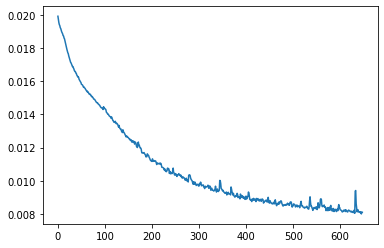

In [21]:
# plot losses (drop first epochs to have a nice plot)
plt.plot(clf.history['train']['loss'][5:])
plt.plot(clf.history['valid']['loss'][5:])

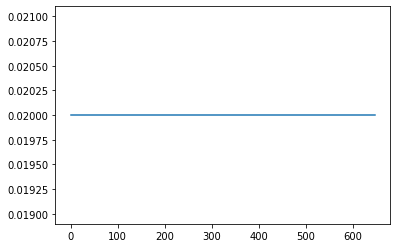

In [22]:
# plot learning rates
plt.plot([x for x in clf.history['lr']][5:])

# Validation

I don't know if people have been looking at these AUCs plots but some tasks are harder than others!

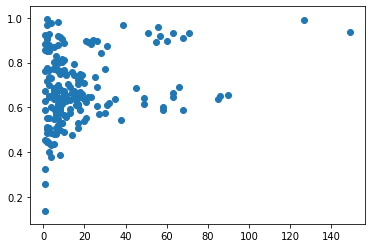

In [23]:
preds_valid = clf.predict_proba(X_valid) # This is a list of results for each task

# We are here getting rid of tasks where only 0 are available in the validation set
valid_aucs = [roc_auc_score(y_score=task_pred[:,1], y_true=y_valid[:, task_idx])
             for task_idx, (task_pred, n_pos) in enumerate(zip(preds_valid, y_valid.sum(axis=0))) if n_pos > 0]

valid_logloss = [log_loss(y_pred=task_pred[:,1], y_true=y_valid[:, task_idx])
             for task_idx, (task_pred, n_pos) in enumerate(zip(preds_valid, y_valid.sum(axis=0))) if n_pos > 0]

plt.scatter(y_valid.sum(axis=0)[y_valid.sum(axis=0)>0], valid_aucs)

In [24]:
# Valid score should match mean log loss - They don't match exactly because we removed some tasks
print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"VALIDATION MEAN LOGLOSS SCORES FOR {dataset_name} : {np.mean(valid_logloss)}")
print(f"VALIDATION MEAN AUC SCORES FOR {dataset_name} : {np.mean(valid_aucs)}")

AttributeError: 'TabNetMultiTaskClassifier' object has no attribute 'best_cost'

## Predictions

In [25]:
preds = clf.predict_proba(X_test)

# Save and load Model

Just an example of how to save and load models in order to use them later

In [15]:
# save tabnet model
saving_path_name = "./TabNetMultiTaskClassifier_baseline"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./TabNetMultiTaskClassifier_baseline.zip


In [16]:
# define new model with basic parameters and load state dict weights (all parameters will be updated)
loaded_clf = TabNetMultiTaskClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cuda
Device used : cuda


In [17]:
loaded_preds = loaded_clf.predict_proba(X_test)

# Make sure that this is working as expected
np.testing.assert_array_equal(preds, loaded_preds)

# Global explainability : feat importance summing to 1

In [33]:
np.array(preds).swapaxes(0, 1).shape

(3982, 206, 2)

In [30]:
y_train.shape

(19020, 206)

# Local explainability and masks for test set

Explain matrix is not normalized so rows don't sum to 1, feel free to normalize them yourself

You can see that attention is quite sparse and this visualization with so many columns is not the best

In [19]:
explain_matrix, masks = clf.explain(X_test)

KeyError: 1

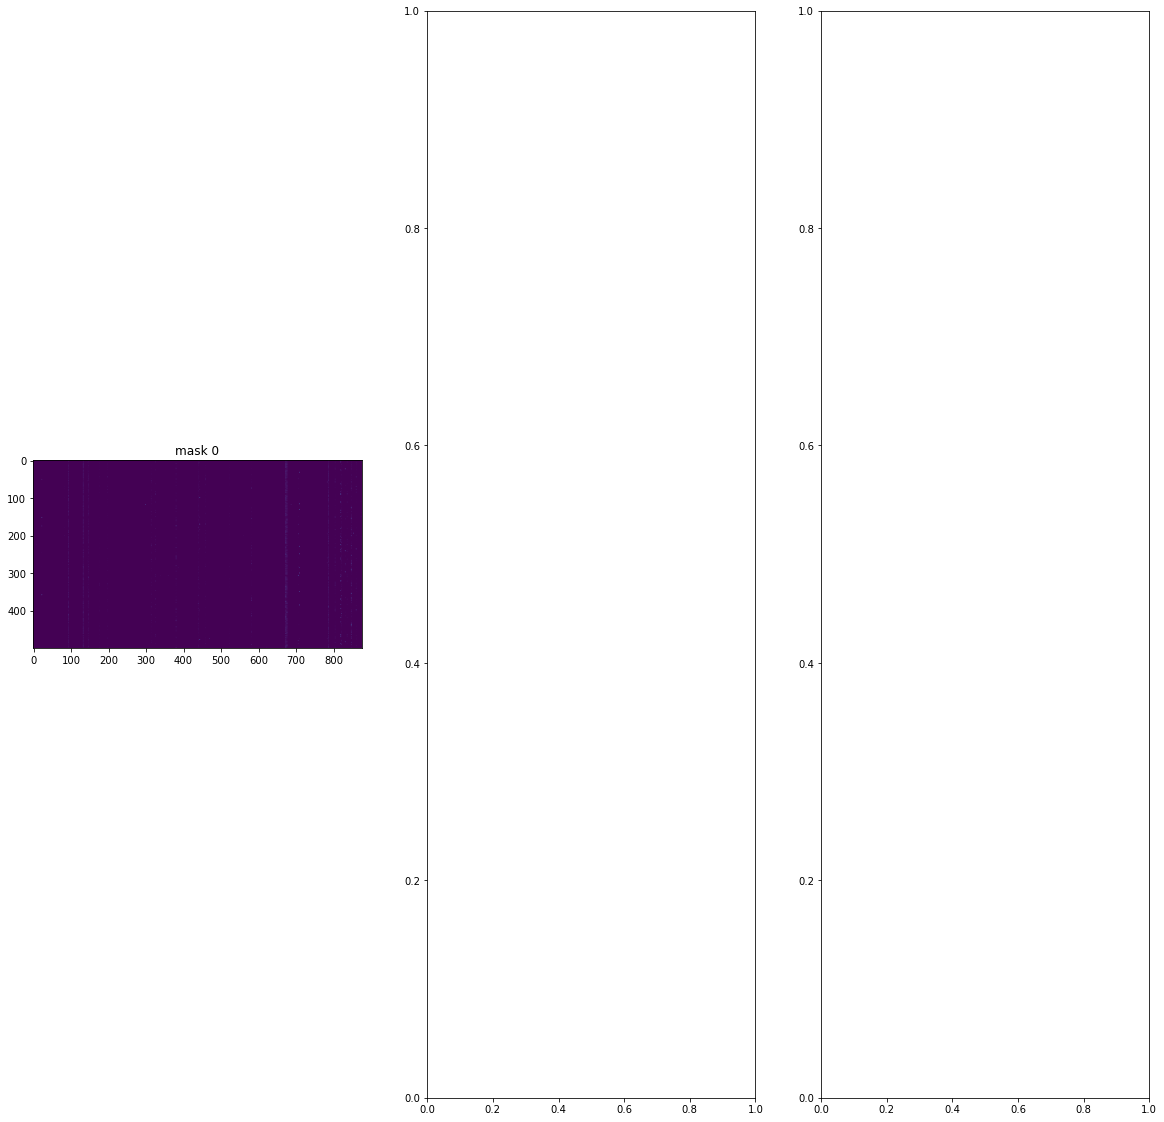

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:500])
    axs[i].set_title(f"mask {i}")


# End of notebook

Hope this will be usefull!